In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [13]:
DEVICE = "cpu"

print(torch.cuda.is_available())
if torch.cuda.is_available():
    DEVICE = "cuda:0"


True


In [14]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
        , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data'
                                             , train=True
                                             , download=True
                                             , transform=transform)
train_loader = DataLoader(train_dataset
                          , batch_size=32
                          , shuffle=True
                          , num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data'
                                            , train=False
                                            , download=True
                                            , transform=transform)
test_loader = DataLoader(test_dataset
                         , batch_size=32
                         , shuffle=False
                         , num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


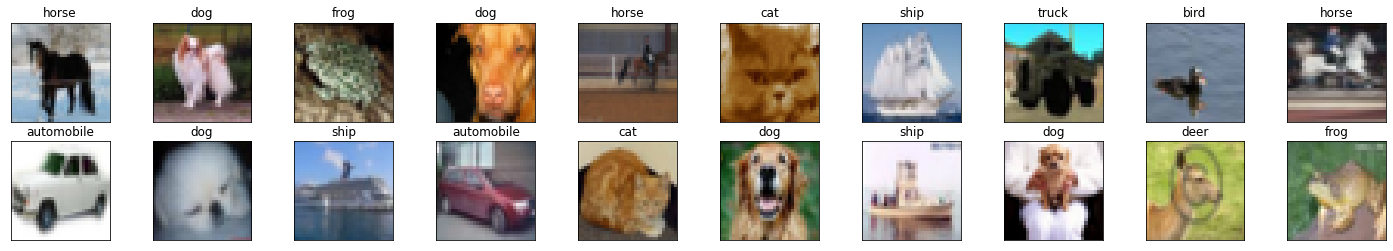

In [16]:
def convert(img):
  img = img.cpu().numpy()
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  img = img.clip(0, 1)
  return img

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
            , nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5)
            , nn.Linear(2304, 64)
            , nn.BatchNorm1d(64)
            , nn.ReLU()
            , nn.Dropout(0.5)
            , nn.Linear(64, 256)
            , nn.BatchNorm1d(256)
            , nn.ReLU()
            , nn.Linear(256, 10) # 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
net = Net()
net.cuda()
net

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
steplr = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [20]:
def train(epoch):
    net.train()
    steplr.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 100 == 0:
            print(f'Train Epoch: {epoch + 1} --> {(batch_idx + 1) * len(data)}/{len(train_loader.dataset)} '
                  f'({100.0 * (batch_idx + 1) / len(train_loader):.0f}%)\tLoss: {loss.data.item():.6f}')

In [21]:
def evaluate(data_loader: DataLoader):
    net.eval()
    LOSS = 0
    CORRECT = 0

    for data, target in data_loader:
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        out = net(data)

        LOSS += F.cross_entropy(out, target, size_average=False).data.item()
        pred = out.data.max(1, keepdim=True)[1]
        CORRECT += pred.eq(target.data.view_as(pred)).cpu().sum()

    LOSS /= len(data_loader.dataset)

    print(f'\nLoss: {LOSS:.4f} \t Val Accuracy: {CORRECT}/{len(data_loader.dataset)} '
          f'({100.0 * CORRECT / len(data_loader.dataset):.3f}%)\n')

In [22]:
EPOCHS = 40

for i in range(EPOCHS):
    train(i)
    evaluate(test_loader)

Train Epoch: 1 --> 3200/50000 (6%)	Loss: 2.032393
Train Epoch: 1 --> 6400/50000 (13%)	Loss: 1.781804
Train Epoch: 1 --> 9600/50000 (19%)	Loss: 1.617952
Train Epoch: 1 --> 12800/50000 (26%)	Loss: 1.553981
Train Epoch: 1 --> 16000/50000 (32%)	Loss: 1.536645
Train Epoch: 1 --> 19200/50000 (38%)	Loss: 1.500364
Train Epoch: 1 --> 22400/50000 (45%)	Loss: 1.437116
Train Epoch: 1 --> 25600/50000 (51%)	Loss: 1.373617
Train Epoch: 1 --> 28800/50000 (58%)	Loss: 1.979260
Train Epoch: 1 --> 32000/50000 (64%)	Loss: 1.369887
Train Epoch: 1 --> 35200/50000 (70%)	Loss: 1.138059
Train Epoch: 1 --> 38400/50000 (77%)	Loss: 1.225916
Train Epoch: 1 --> 41600/50000 (83%)	Loss: 1.126489
Train Epoch: 1 --> 44800/50000 (90%)	Loss: 1.220506
Train Epoch: 1 --> 48000/50000 (96%)	Loss: 1.443474

Loss: 1.1975 	 Val Accuracy: 5650/10000 (56.500%)

Train Epoch: 2 --> 3200/50000 (6%)	Loss: 1.283187
Train Epoch: 2 --> 6400/50000 (13%)	Loss: 1.214864
Train Epoch: 2 --> 9600/50000 (19%)	Loss: 1.305038
Train Epoch: 2 --> 1

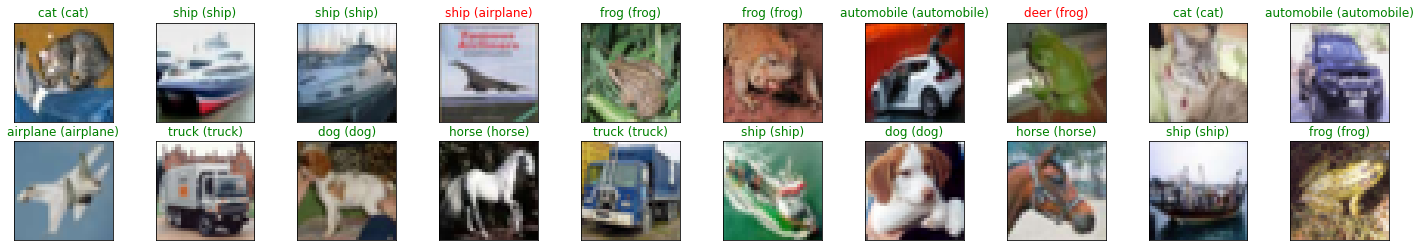

In [23]:
dataiter = iter(test_loader)
img, label = dataiter.next()
img = img.to(DEVICE)
label = label.to(DEVICE)
out = net(images)
_, pred = torch.max(out, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert(images[idx]))
  ax.set_title(f'{str(classes[pred[idx].item()])} ({str(classes[labels[idx].item()])})'
               , color=("green" if pred[idx]==labels[idx] else "red"))

## `Model accuracy --> 83.6%!`
